# Impact Chart Demo - Synthetic Data

This is a demonstration of impact chart analysis on a synthetic data set.

This demo is designed to illustrate the power of impact charts,
and in particular how they can tease out the effects of features even when 
regression analysis does not make them clear.

In [1]:
from impactchart.model import XGBoostImpactModel

from impactchartdemo.dataset import synth1

import numpy as np
import pandas as pd
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
from matplotlib.figure import Figure

## Generate the Data Set

We will being with a data set. It has five features (a.k.a. independent variables)
$x_0$ through $x_4$. It also has a single target (a.k.a. dependent variable) $y$.

In [2]:
N = 200

In [3]:
X, y = synth1.get_data(N)

Here is a sample of what some of the $x_i$ and $y$ values look like:

In [4]:
X.head(10)

,x_0,x_1,x_2,x_3,x_4
0,-41.066999,6.117351,-61.695843,-86.419928,57.397092
1,31.266704,27.504179,15.120579,-92.187417,-28.437279
2,89.136637,-87.991064,72.808421,75.458105,-89.761267
3,30.483723,10.350274,19.502651,-3.294275,-43.402368
4,-40.454856,12.301781,-20.790513,57.740142,-16.303123
5,-71.219216,-69.818661,-88.951730,43.607439,-41.536529
6,-60.245226,66.272784,13.598224,-83.532050,8.999715
7,-68.208251,35.352477,-76.305547,-11.000787,77.596487
8,59.453546,-86.404254,92.157551,31.841078,43.755217
9,48.715353,77.547270,-73.210866,55.394916,67.598302


In [5]:
pd.DataFrame(y).head(10)

,y
0,120.059983
1,207.205241
2,-30.919692
3,231.453278
4,-11.131830
5,7.097398
6,2.322624
7,100.141805
8,-30.203469
9,149.031201


## Exploratory Data Analysis (EDA)

The first thing we generally do with a new data set is some exploratory
data analysis and a bit of regression analysis over some scatter plots.
We'll do both here. 

These are certainly not the limit of what we can do in EDA, but they are
common starting points.

### EDA 1: Histograms

We will make a histogram of the $y$ values. It looks somewhat like a normal distribution, but 
otherwise, it's not particularly noteworthy.

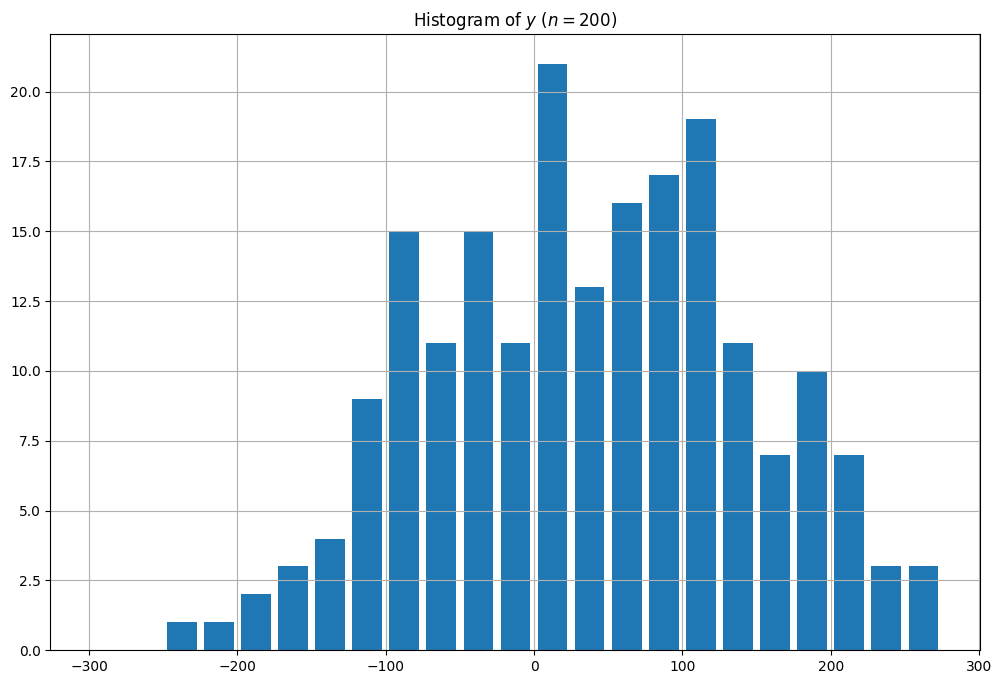

In [6]:
fig, ax = plt.subplots(figsize=(12, 8))
ax.hist(y, bins=range(-300, 300, 25), rwidth=0.8)
ax.set_title(f"Histogram of $y$ ($n = {N}$)")
ax.grid()

Next, we will make some histograms of the $x_i$. None of them look perfectly uniform, but they aren't terribly far off.

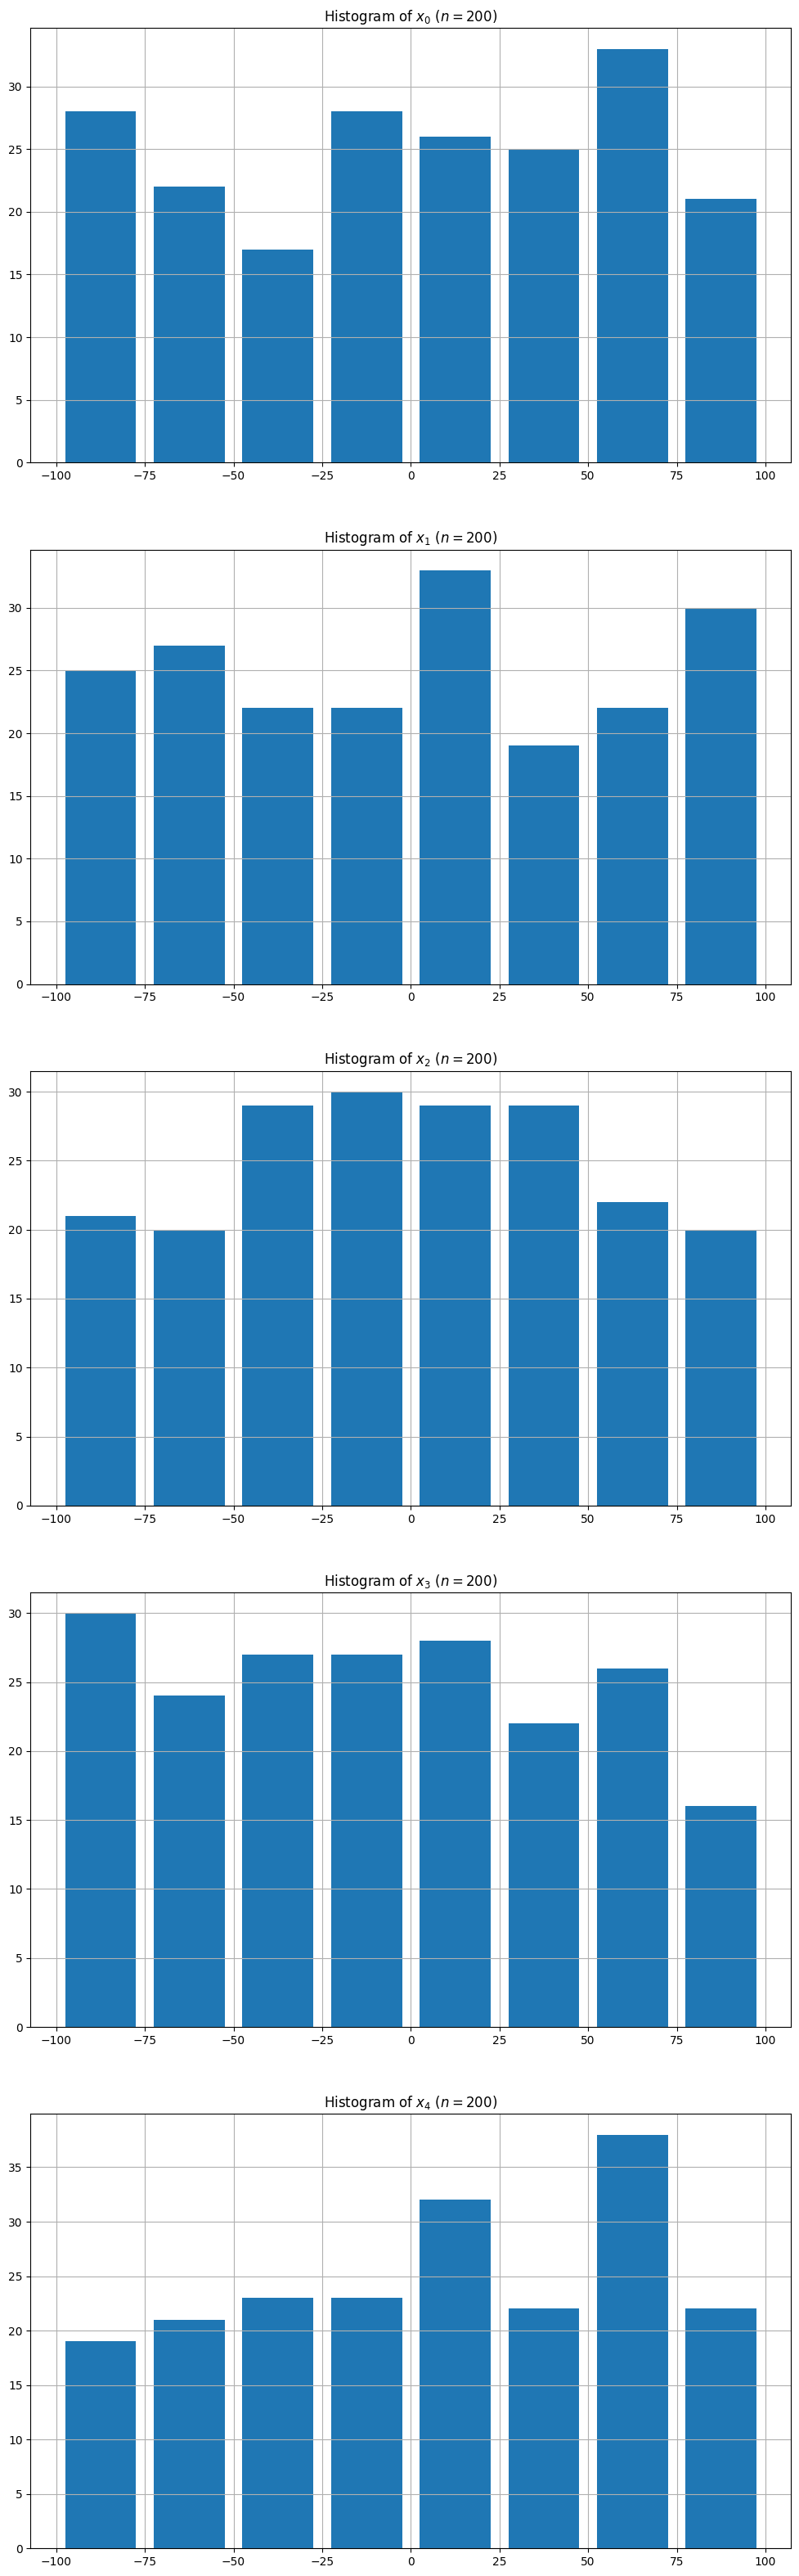

In [7]:
fig, axes = plt.subplots(len(X.columns), 1, figsize=(12, 8 * len(X.columns)))

for x_col, ax in zip(X.columns, axes):
    ax.hist(X[x_col], bins=range(-100, 101, 25), rwidth=0.8)
    ax.set_title(f"Histogram of ${x_col}$ ($n = {N}$)")
    ax.grid()

### EDA 2: Scatter Plots with Regression Curves

The next thing we will do is generate a scatter plot of $y$ against each of the $x_i$.
On top of that, we will plot a two regression curves, one linear and one quadratic.

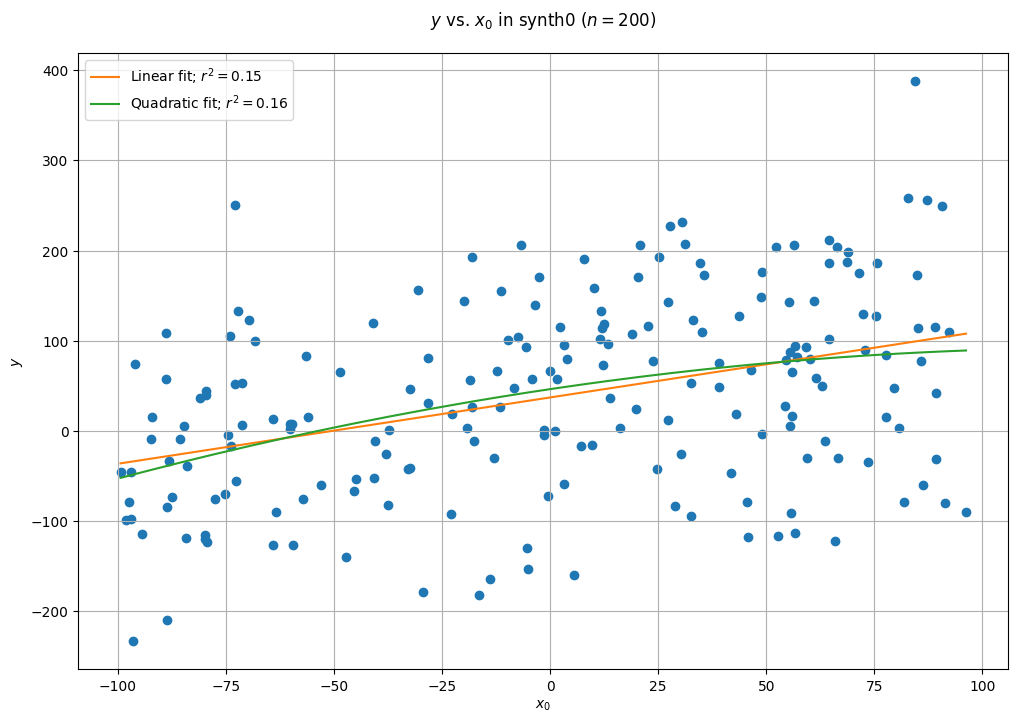

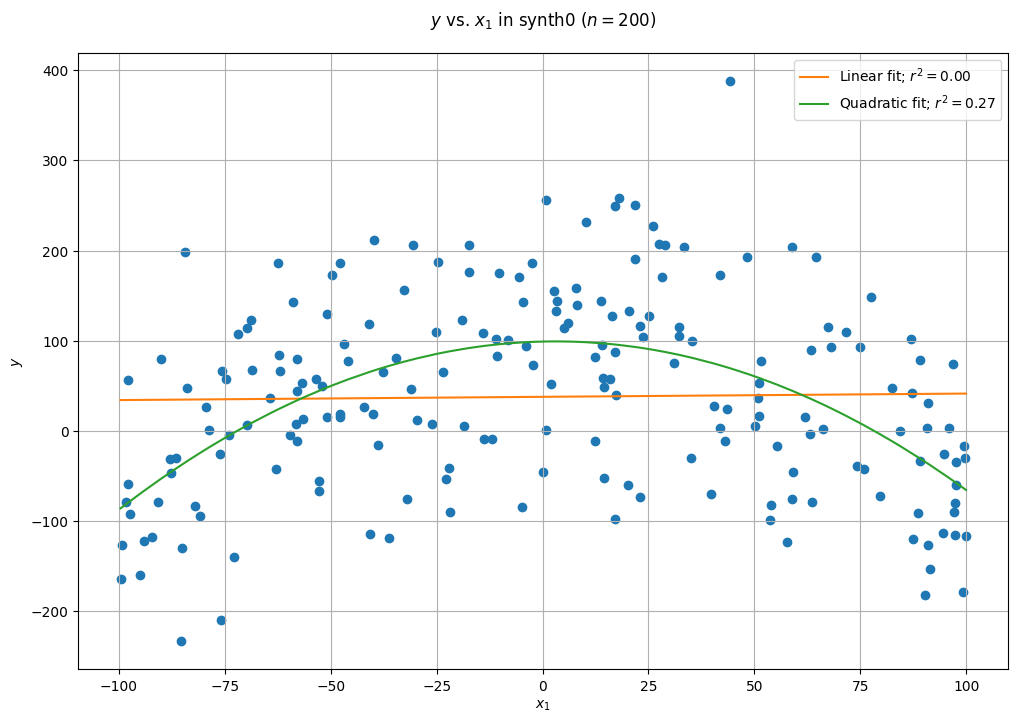

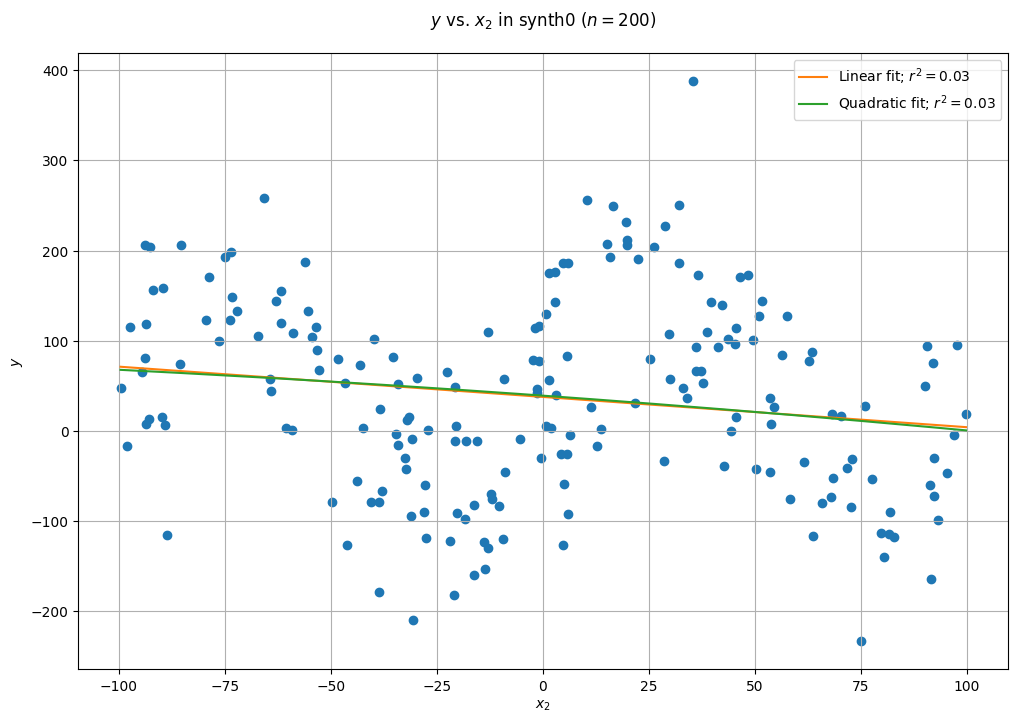

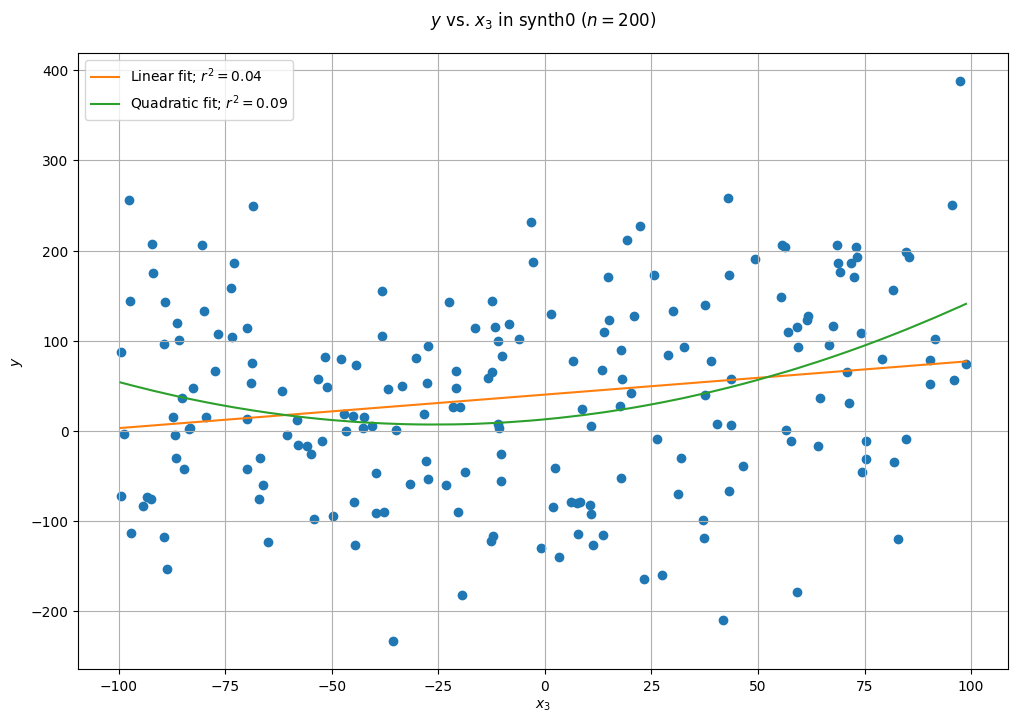

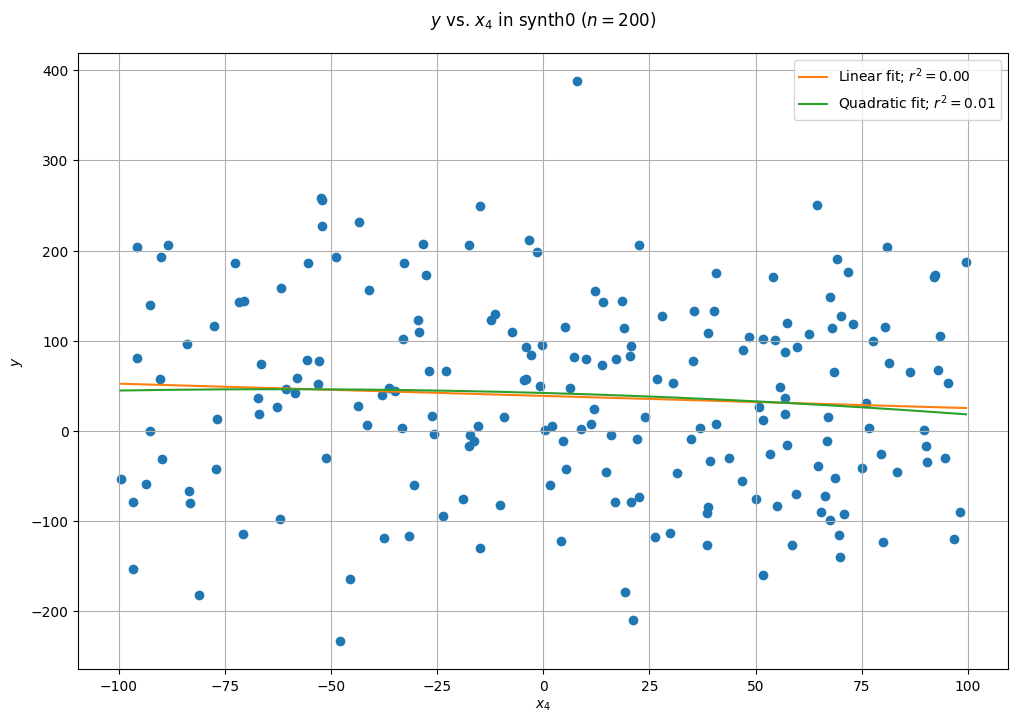

In [8]:
for ii in range(len(X.columns)):

    fig, ax = plt.subplots(figsize=(12, 8))
    
    col = f'x_{ii}'
    ax.scatter(X[col], y, c="C0")

    sx = X[col].sort_values()
    sy = y.sort_values()
    y_bar = sy.mean()

    ss = ((sy - y_bar) ** 2).sum()

    # Linear fit:
    m_linear, b_linear = np.polyfit(X[col], y, 1)

    y_linear = m_linear * sx + b_linear

    ss_reg_linear = ((y_linear - y_bar) ** 2).sum()
    
    r2_linear = ss_reg_linear / ss
    
    ax.plot(sx, y_linear, c="C1", label=f"Linear fit; $r^2 = {r2_linear:0.2f}$")

    # Quadratic fit:
    a_quadratic, b_quadatic, c_quadratic = np.polyfit(X[col], y, 2)

    y_quadratic = a_quadratic * sx * sx + b_quadatic * sx + c_quadratic

    ss_reg_quadratic = ((y_quadratic - y_bar) ** 2).sum()
    
    r2_quadratic = ss_reg_quadratic / ss
    
    ax.plot(sx, y_quadratic, c="C2", label=f"Quadratic fit; $r^2 = {r2_quadratic:0.2f}$")
    
    ax.legend()
    ax.set_title(f"$y$ vs. ${col}$ in synth0 ($n = {N}$)", pad=20) 
    ax.set_xlabel(f"${col}$")
    ax.set_ylabel('$y$')
    
    ax.grid()

Looking at the scatter plots, we see that $x_0$ might have a linear effect on $y$ and
$x_1$ might have a quadratic effect. But neither effect is obviously all that strong.
And the remaining features $x_2$, $x_3$, and $x_4$ don't have any obvious effect on
$y$.

We could, of course, try out some more advanced methods to tease out the relationships,
but for now, we are going to jump to impact chart analysis, which, as we will see,
will give us a lot more insight very quickly.

## Impact Chart Analysis (ICA)

Impact chart analysis is designed to visually indicate how each of the $x_i$ impact $y$. 
To use it, we construct and fit an impact model, then ask it for plots.

### ICA 1: Construct and Fit

In [9]:
impact_model = XGBoostImpactModel()

In [10]:
%%time

impact_model.fit(X, y)

Fitting 5 folds for each of 200 candidates, totalling 1000 fits
CPU times: user 28.1 s, sys: 20.7 s, total: 48.8 s
Wall time: 22.4 s


### ICA 2: Plot

Each of these plots shows us the _impact_ of different observed values of one of the $x_i$ on $y$. 
The green dots are our estimate of the impact and the grey dots indicate a form of confidence interval
vertically around them.

CPU times: user 40.5 s, sys: 11.7 s, total: 52.2 s
Wall time: 27.8 s


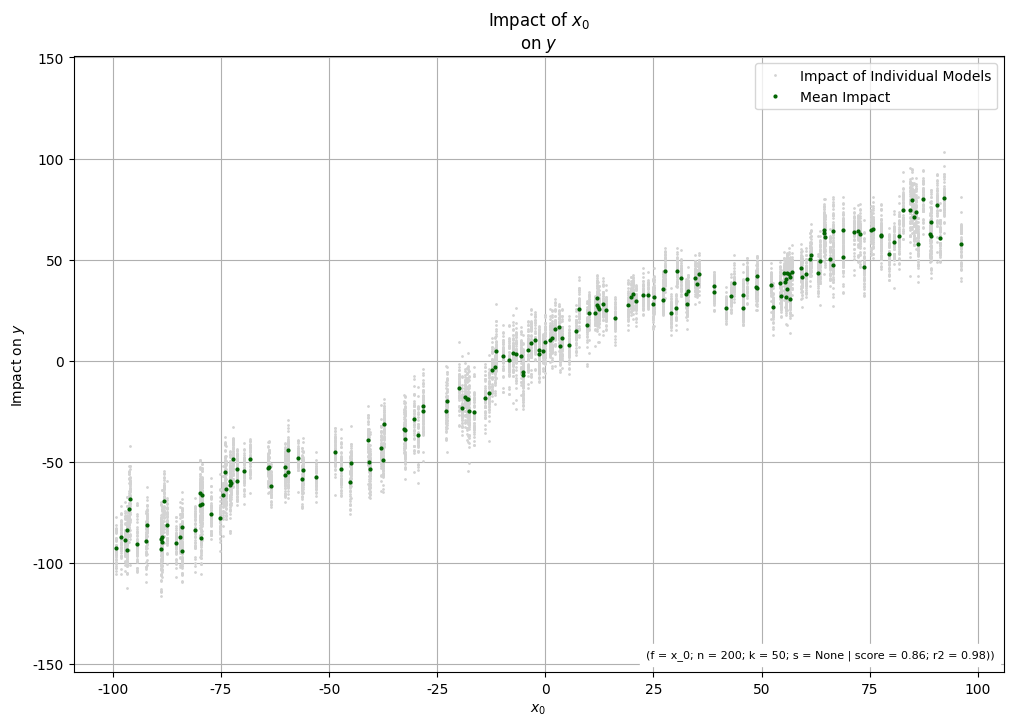

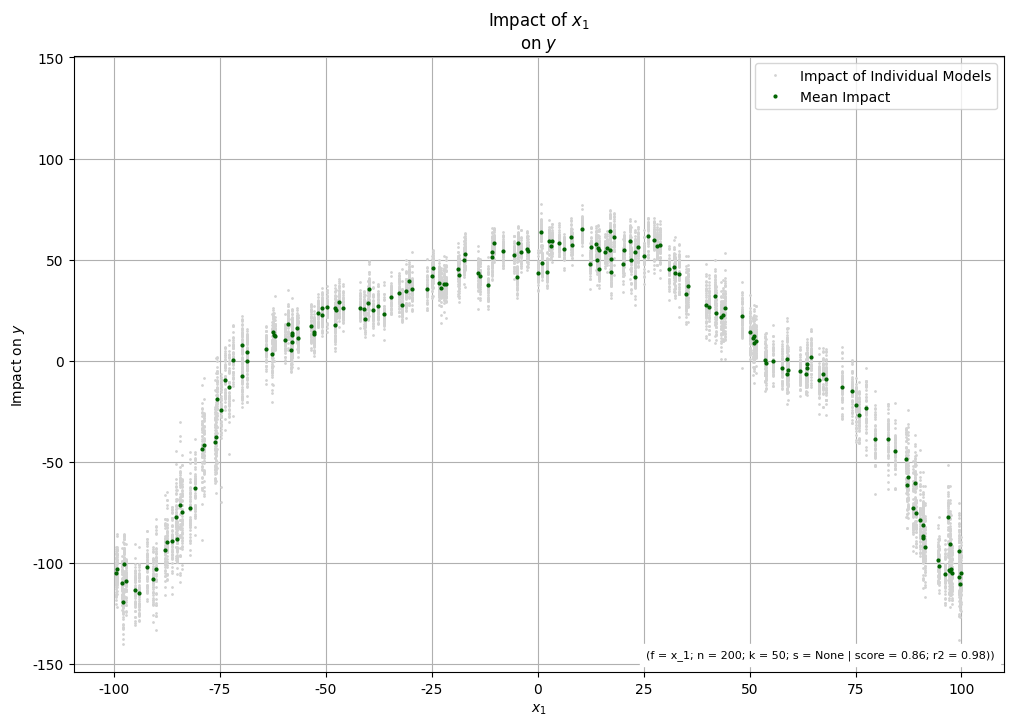

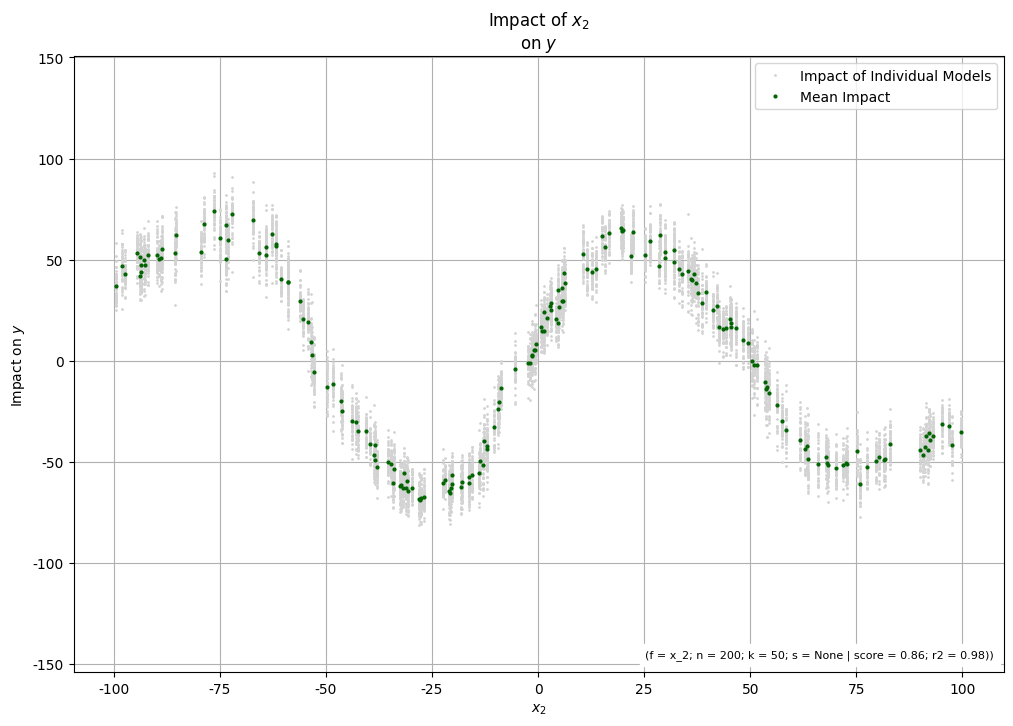

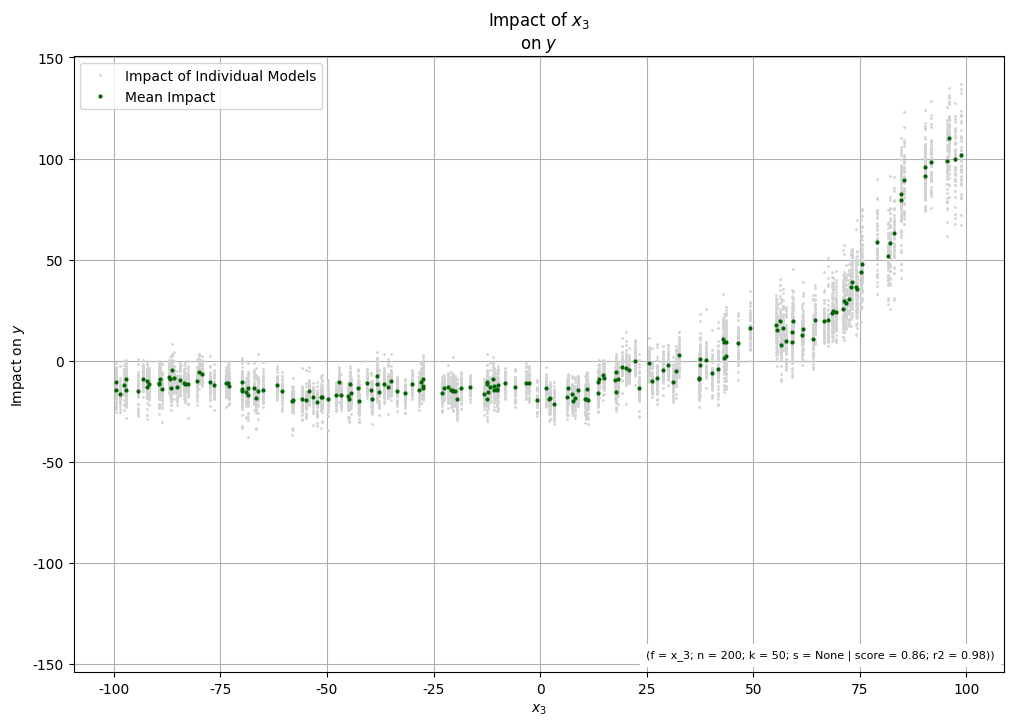

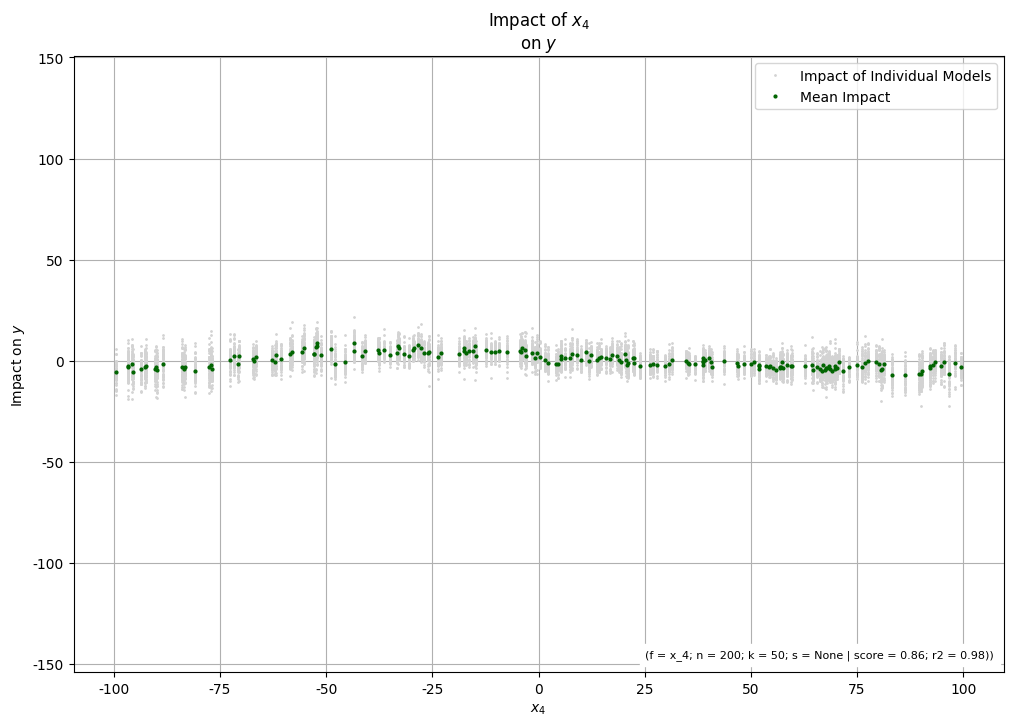

In [11]:
%%time

impact_charts = impact_model.impact_charts(
    X, X.columns, 
    feature_names = {col: f"${col}$" for col in X.columns},
    y_name = "$y$",
    subplots_kwargs=dict(figsize=(12, 8))
)

Note that the vertical axis in these impact charts is not $y$, but rather the impact
that a particular value of $x_i$ had on $y$. For any given point $(x_0, x_1, \ldots x_4)$
the sum of the impacts plus the mean value of $y$ equals the value of $y$ seen for
that point. In a sense, what we have done is broken down the value of $y$ into 
additive parts that can be explained by the values of each of the $x_i$.

Looking at the impact charts, we see that $x_0$ again has a linear effect on $y$, with
tight error bars (indicated in grey). 
$x_1$ appears to have a quadratic effect. We saw some evidence of these effects above,
but it is stronger here.

Moving on to the other features, the impact of $x_2$ appears to be sinusoidal. $x_3$
does not appear to have much impact at all. Finally, $x_4$ has a nonlinear impact, 
possibly an exponential one.

## Behind the Green Curtain

Most of the time when we are analyzing a data set, we don't have direct
access to the underlying process that produced it. But in this case, the
data is synthetic, so we do. As a result, we can compare the impact
chart to the process that created the data.

The synthetic data is generated as the sum of four terms $t_i$ plus some normally distributed noise as follows:

$$y = \sum_{i = 0}^4 t_i + N(0, 10)$$

Each term $t_i$ in turn is a function of $x_i$, but not of $x_j$ for any $j \ne i$.
In particular,

$$t_0 = x_0;$$

$$t_1 = 100 * \left(1 - 2  \left( \frac{x_1}{100} \right)^2 \right);$$

$$t_2 = 100 \sin\left(2 \pi \frac{x_2}{100}\right);$$

$$t_3 = 200 * \exp \left[ 7 \left(\frac{x_3}{100} - 1 \right) \right];$$

$$t_4 = 0.$$

So $t_0$ is linear in $x_0$; $t_1$ is quadratic in $x_1$; $t_2$ is sinusoidal in $x_2$; $t_3$ is exponential in $x_3$; and $t_4$ is a constant regardless of the value
of $x_4$.

If these terms sound vaguely like the shapes of the impact charts, it's because they are. The impact chart analysis
found the impact of these terms even though it had no advanced knowledge of them or even of any set of parametric 
equations that might define them. We gave the impact chart code no information whatsoever about what to expect.
We only gave it the raw $X$ and $y$. The machine learning algorithms embedded in the impact chart code have no idea
what shapes they are looking for.

To see just how good a job impact chart analysis did, we can plot the terms $t_i$ over the top of the corresponding
impact charts for $x_i$. This results in the charts shown below.

In [12]:
for x_col in X.columns:
    df_sx = X.sort_values(by=x_col)
    fig, ax = impact_charts[x_col]
    ax.plot(df_sx[x_col], synth1.term(x_col)(df_sx), c="C1", label=f"Original term ${x_col.replace('x_', 't_')}$")
    ax.legend()

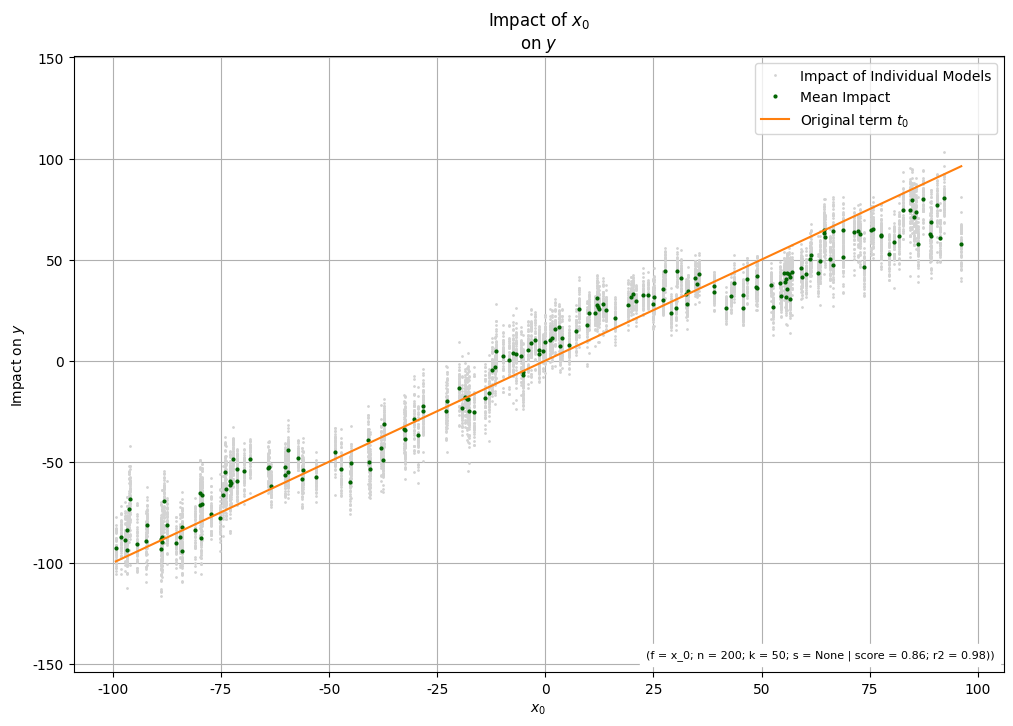

In [13]:
impact_charts['x_0'][0]

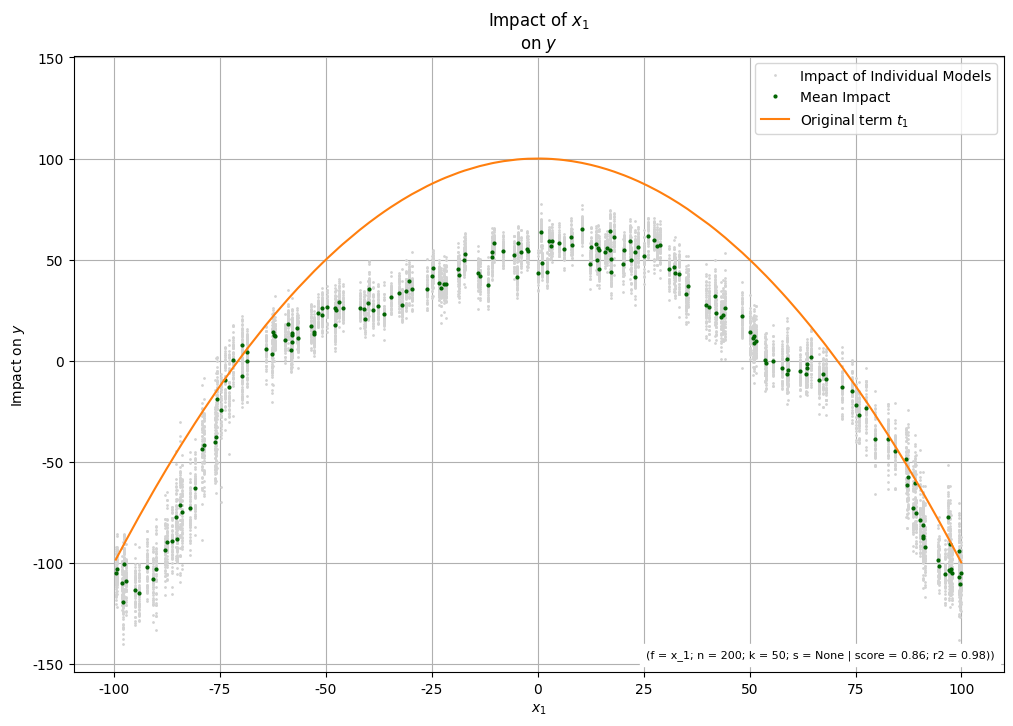

In [14]:
impact_charts['x_1'][0]

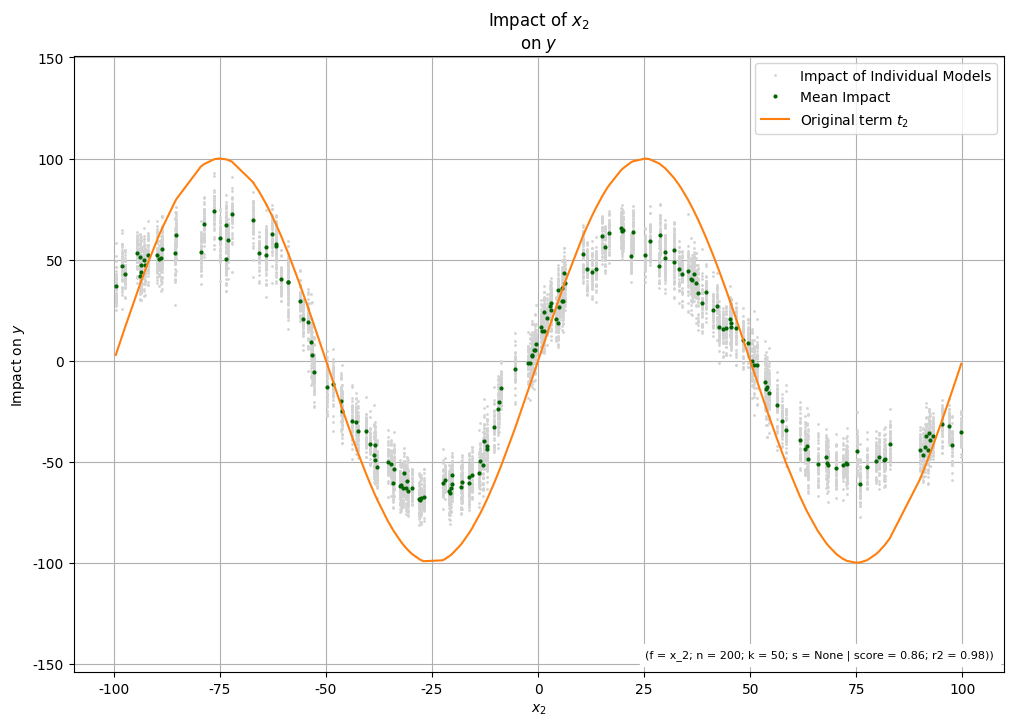

In [15]:
impact_charts['x_2'][0]

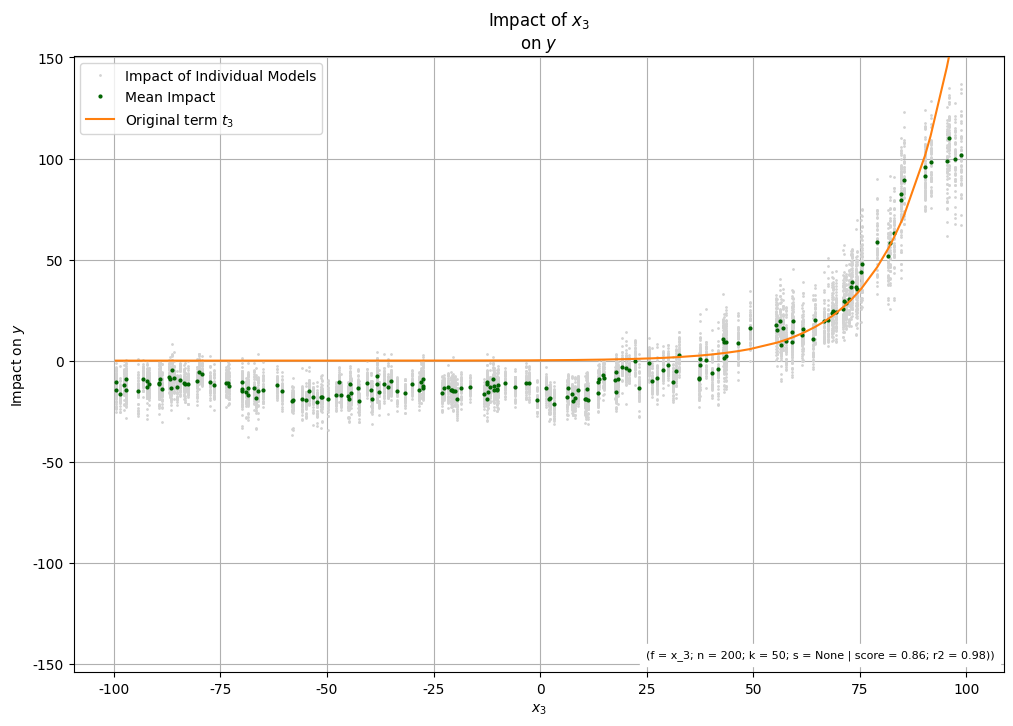

In [16]:
impact_charts['x_3'][0]

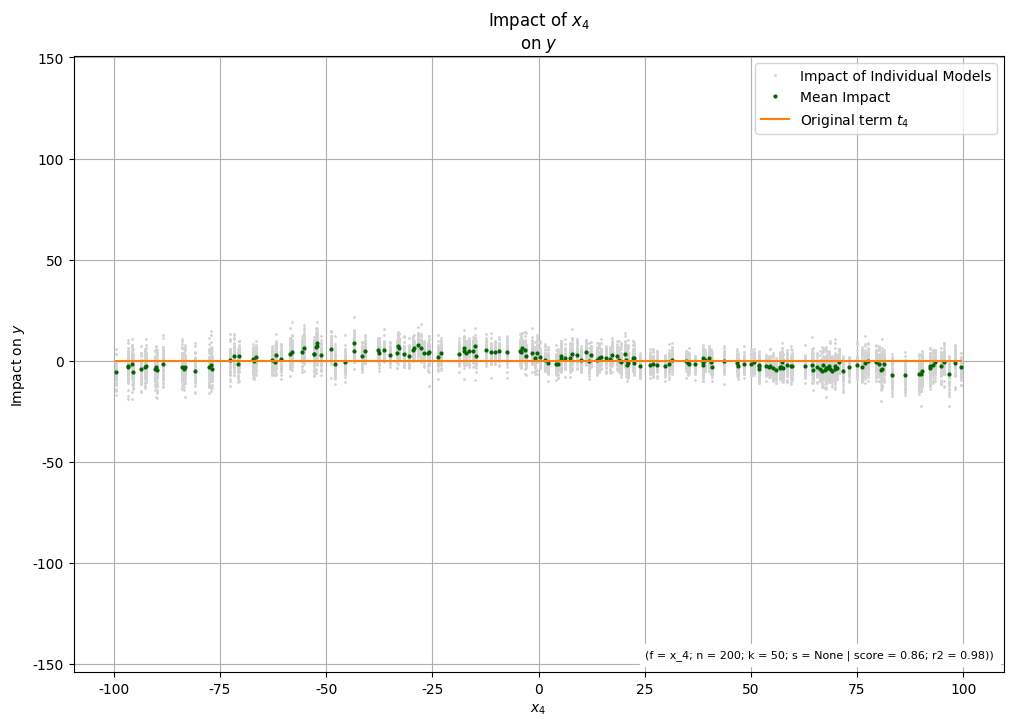

In [17]:
impact_charts['x_4'][0]

The matches are not perfect, but they are quite close, and absolutely capture the character of the underlying terms $t_i$.

It is important to note that the machine learning models underlying the impact charts did not attempt to classify the
impacts as linear, quadratic, sinusoidal, or exponential. They have no impliciit or explicit knowledge of these 
kinds of curves or any others. Rather, we asked the models to learn to predict $y$ when given the $x_i$ as accurately
as possible, then interrogated them as to how and why they made certain predictions, and used that information to create
impact charts.